<a href="https://www.goes-r.gov/">
<img src='./GOES-R_logo_small.png' style="height:150px" align=right alt="National Weather Service">
</a>

# GOES-16: Fire Temperature Recipe
__Brian Blaylock__ | _blaylock@gmail.com_ | [_website_](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/home.html)   |  
__May 24, 2018__  


This Python notebook shows how to make the GOES-16 Fire Temperature product and plot it on different map projections using `pyproj` and `Basemap`. 

Other Notebooks: |[True Color](https://github.com/blaylockbk/pyBKB_v2/blob/master/BB_GOES16/mapping_GOES16_data.ipynb)|[GLM Lightning](https://github.com/blaylockbk/pyBKB_v2/blob/master/BB_GOES16/mapping_GOES16_GeostationaryLightningMapper.ipynb)|


The Fire Temperature product is an RGB composite image of the following three channels:

|          | Wavelength  | Channel | Description |
|----------|:-----------:|:-------:|:-----------:|
| **Red**  | 3.9 &#181;m |    7    | Shortwave Window|
| **Green**| 2.2 &#181;m |    6    | Cloud Particle Size|
| **Blue** | 1.6 &#181;m |    5    | Snow/Ice|


##### Download GOES-16 Data
For this demo, you will first need a GOES-16 data file. You can get GOES-16 files from [NOAA's Amazon S3 GOES Archive](https://aws.amazon.com/public-datasets/goes/). I created a [web interface](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi) to easily download files from the Amazon archive. This example uses the [level 2 _multiband_ formatted file for the _CONUS_ domain](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi?domain=C&product=ABI-L2-MCMIP&hour=0). These files contains all 16 bands on the same 2 km resolution grid.

----------

### First, import some libraries we will use

In [2]:
%matplotlib inline

from netCDF4 import Dataset
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# pyproj is used to regrid the data on a Basemap. 
try:
    from pyproj import Proj       
except:
    # Note to self: Since pyproj is not installed on meteo19, load it this way
    import sys
    sys.path.append('/uufs/chpc.utah.edu/sys/pkg/python/2.7.3_rhel6/lib/python2.7/site-packages/')
    from pyproj import Proj

### Open and Read the GOES-16 NetCDF File

In [3]:
# I previously downloaded this file from AWS
C_file = '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/ABI-L2-MCMIPC/20180524/OR_ABI-L2-MCMIPC-M3_G16_s20181441732249_e20181441735022_c20181441735136.nc'
C = Dataset(C_file, 'r')

### Image's Date/Time Information

In [4]:
# Seconds since 2000-01-01 12:00:00
add_seconds = C.variables['t'][0]

# Datetime of image scan
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

### Fire Temperature Recipe
From Chad Gravell _chad.gravelle@noaa.gov_

##### Red
- 3.9 um (Band 7)  
- brightness temperature range [273-333] Kelvin  
- gamma correction of 2.5 (Note: Chad told me the gamma value was 0.4, but the reciprocal gives me the correct values)

##### Green
- 2.25 um (Band 6)
- reflectance range [0-1]

##### Blue
- 1.6 um (Band 5)
- reflectance range [0-0.75]

In [14]:
# Confirm that each band is the wavelength we are interested in
for b in [7, 6, 5]:
    print "%s is %s %s" % (C.variables['band_wavelength_C%02d' % b].long_name,
                           C.variables['band_wavelength_C%02d' % b][0],
                           C.variables['band_wavelength_C%02d' % b].units)

ABI band 7 central wavelength is 3.89 um
ABI band 6 central wavelength is 2.25 um
ABI band 5 central wavelength is 1.61 um


In [15]:
# Load the RGB arrays
R = C.variables['CMI_C07'][:].data
G = C.variables['CMI_C06'][:].data
B = C.variables['CMI_C05'][:].data

# Turn empty values into nans
R[R==-1] = np.nan
G[G==-1] = np.nan
B[B==-1] = np.nan

# Apply range limits for each channel (mostly important for Red channel)
R = np.maximum(R, 273)
R = np.minimum(R, 333)
G = np.maximum(G, 0)
G = np.minimum(G, 1)
B = np.maximum(B, 0)
B = np.minimum(B, .75)

# Normalize each channel by the appropriate range of values (again, mostly important for Red channel)
R = (R-273)/(333-273)
G = (G-0)/(1-0)
B = (B-0)/(.75-0)

# Apply the gamma correction to Red channel.
#   I was told gamma=0.4, but I get the right answer with gamma=2.5 (the reciprocal of 0.4)
R = np.power(R, 2.5)

# The final RGB array :)
RGB = np.dstack([R, G, B])

### Plot on a Basemap: Geostationay Projection
The data is in a [geostationary projection](http://proj4.org/projections/geos.html). We need to extract the image's projection metadata from the file.

In [16]:
# Satellite height
sat_h = C.variables['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C.variables['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = C.variables['x'][:] * sat_h
Y = C.variables['y'][:] * sat_h

In [17]:
# The geostationary projection is perhaps the easiest way to plot the image on a map.
# Essentially, we are stretching the image across a map with the same projection and dimensions.
m = Basemap(projection='geos', lon_0=sat_lon,
            resolution='i', area_thresh=5000,
            llcrnrx=X.min(),llcrnry=Y.min(),
            urcrnrx=X.max(),urcrnry=Y.max())

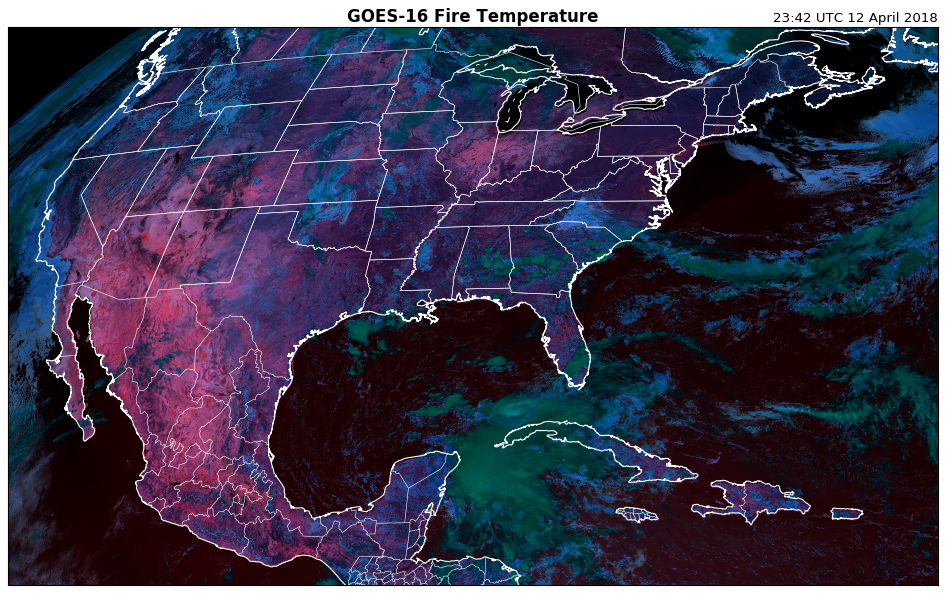

In [18]:
plt.figure(figsize=[15, 12])
m.imshow(np.flipud(RGB)) # Remember, "images" are upside down, so flip up/down
m.drawcoastlines(color='w')
m.drawcountries(color='w')
m.drawstates(color='w')

plt.title('GOES-16 Fire Temperature', fontweight='semibold', fontsize=15)
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right')

### What about for other projections?

The problem with the above image is that it is not georeferenced. We do not know where in the world each pixel lies. The GOES-16 file contains all the metadata needed to understand the map projection of the image. We will use this metadata and `pyproj` to calculate the latitude and longitude of each pixel so we can project the image onto other maps. This is done by using an inverse transformation of the map projection object, `p`, of the map coordinates given by X and Y. Since the satellite doesn't move, you can do this calculation once and save the latitude and longitude arrays for later use. I have saved these arrays in an HDF5 file [here](https://pando-rgw01.chpc.utah.edu/GOES16/goes16_conus_latlon_east.h5) you may use.

#### The magic function: `pyproj.Proj`
This function creates a map projection object of the geostationary projection.

In [19]:
# map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

In [20]:
# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

lats[np.isnan(R)] = np.nan
lons[np.isnan(R)] = np.nan
# ^ Please take a moment and appreciate those two lines. Before adding this seemingly simple and unimportant step,
#   the plots were getting messed up. I contemplated why that was happening during a 2-hr commute home, while cooking
#   dinner, watching an hour of Gone With the Wind with my wife, and while sleeping for 7 hours. At breakfast I figured
#   it out! I had to mask the empty data with nans like I did with the RGB values. During the first 2 minutes of work,
#   I added these two lines and now everything from here on down works!

 ### Plot on a Basemap: Lambert Conformal Projection
 I am going to project the GOES-16 data on the Lambert Conformal Projection used by the [HRRR](https://rapidrefresh.noaa.gov/hrrr/) model.

In [21]:
# Make a new map object for the HRRR model domain map projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=1800*3000, height=1060*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

We cannot simply plot the reprojected image with `imshow` because the pixels are spaced irregularly. We have to use `pcolormesh`, which is not a trivial task. We need to create a color tuple for each pixel. Details on doing this are on stackoverflow [here](https://stackoverflow.com/questions/29232439/plotting-an-irregularly-spaced-rgb-image-in-python) and [here](https://stackoverflow.com/questions/41389335/how-to-plot-geolocated-rgb-data-faster-using-python-basemap). Below is my method.

In [22]:
# Create a color tuple for pcolormesh
rgb = RGB[:,:-1,:] # Using one less column is very imporant, else your image will be scrambled! (This is the stange nature of pcolormesh)
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array, becuase that's what pcolormesh wants.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel will plot faster, according to stackoverflow. Not sure why.

/uufs/chpc.utah.edu/sys/installdir/python/2.7.11-c7/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/colors.py:405: RuntimeWarning: invalid value encountered in greater
  if (c.ravel() > 1).any() or (c.ravel() < 0).any():
/uufs/chpc.utah.edu/sys/installdir/python/2.7.11-c7/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/colors.py:405: RuntimeWarning: invalid value encountered in less
  if (c.ravel() > 1).any() or (c.ravel() < 0).any():


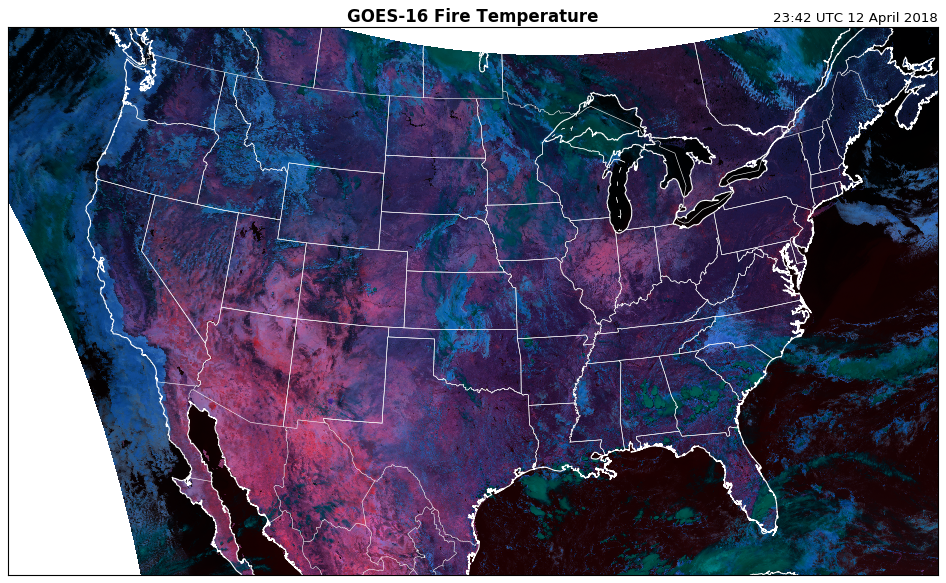

In [23]:
# Now we can plot the GOES data on the HRRR map domain and projection
plt.figure(figsize=[15, 12])

# The values of R are ignored becuase we plot the color in colorTuple, but pcolormesh still needs its shape.
newmap = mH.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None) # without this line the linewidth is set to zero, but the RGB colorTuple is ignored. I don't know why.

mH.drawcoastlines(color='w')
mH.drawcountries(color='w')
mH.drawstates(color='w')

plt.title('GOES-16 Fire Temperature', fontweight='semibold', fontsize=15)
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right')

 ### Plot on a Basemap: Cylindrical Projection
 The fire temperature product is most useful when the domain is zoomed in on a fire. The Buzzard wildfire in New Mexico was burning during this scan, so let's zoom in on that fire...

In [24]:
# Location of Buzzard Fire
l = {'latitude': 33.724,
     'longitude': -108.538}

# Draw zoomed map
mZ = Basemap(resolution='i', projection='cyl', area_thresh=50000,\
             llcrnrlon=l['longitude']-2.25, llcrnrlat=l['latitude']-2.25,\
             urcrnrlon=l['longitude']+2.25, urcrnrlat=l['latitude']+2.25,)

/uufs/chpc.utah.edu/sys/installdir/python/2.7.11-c7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:4726: RuntimeWarning: invalid value encountered in greater
  lonsin1 = np.where(lonsin1 > lon_0+180, lonsin1-360 ,lonsin1)
/uufs/chpc.utah.edu/sys/installdir/python/2.7.11-c7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:4727: RuntimeWarning: invalid value encountered in less
  lonsin1 = np.where(lonsin1 < lon_0-180, lonsin1+360 ,lonsin1)
/uufs/chpc.utah.edu/sys/installdir/python/2.7.11-c7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:4731: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = nlons-np.where(londiff>=thresh)[0]


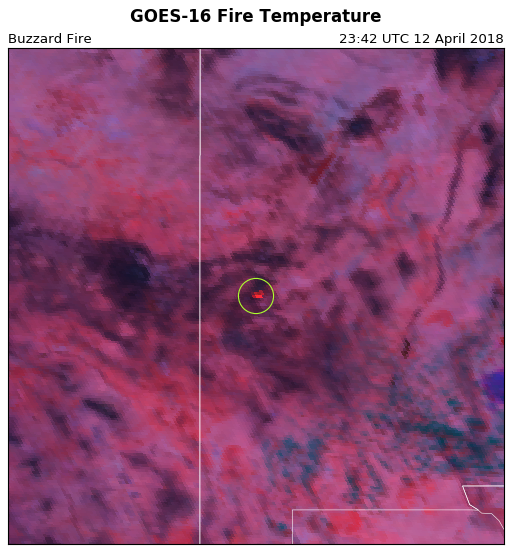

In [25]:
# Now we can plot the GOES data on a zoomed in map centered on the Buzzard wildfire
plt.figure(figsize=[8, 8])

# The values of R are ignored becuase we plot the color in colorTuple, but pcolormesh still needs its shape.
newmap = mZ.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None) # without this line, the linewidth is set to zero, but the RGB colorTuple is ignored. I don't know why.

# Draw outline around the fire...
mZ.scatter(l['longitude'], l['latitude'], marker='o', s=1000, facecolor='none', edgecolor='greenyellow')

mZ.drawcoastlines(color='w')
mZ.drawcountries(color='w')
mZ.drawstates(color='w')

plt.title('GOES-16 Fire Temperature\n', fontweight='semibold', fontsize=15)
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right')
plt.title('Buzzard Fire', loc='left')

# Fire Temperature and True Color Blend
You can blend the true color and fire temperature product after you retrieve the RGB array for both products. I do all this work in the following two functions. Blend the RGB color tuple by finding the max RGB value between the two arrays. Something like this:

    max_RGB = np.nanmax([F['rgb_tuple'], G['rgb_tuple']], axis=0)